In [2]:
import math
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage
import tensorflow as tf
from tensorflow.python.framework import ops


%matplotlib inline
np.random.seed(1)

In [3]:
def load_dataset():
    train_dataset = h5py.File('datasets/train_signs.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels

    test_dataset = h5py.File('datasets/test_signs.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels

    classes = np.array(test_dataset["list_classes"][:]) # the list of classes
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

In [4]:
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = load_dataset()

y = 2


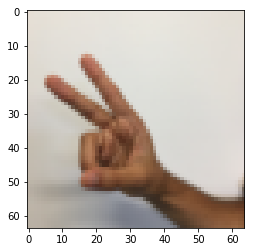

In [5]:
# Example of a picture
index = 6
plt.imshow(X_train_orig[index])
print ("y = " + str(np.squeeze(Y_train_orig[:, index])))

In [7]:
def one_hot_matrix(labels,C):
    one_hot_m=tf.one_hot(indices=labels,depth=C,axis=0)
    sess=tf.Session()
    one_hot=sess.run(one_hot_m)
    sess.close()
    return one_hot

In [16]:
X_train_flatten=X_train_orig.reshape(X_train_orig.shape[0],-1).T
X_test_flatten=X_test_orig.reshape(X_test_orig.shape[0],-1).T

X_train=X_train_flatten/255
X_test=X_test_flatten/255
Y=np.squeeze(Y_train_orig)

Y_train=one_hot_matrix(np.squeeze(Y_train_orig),6).T
Y_test=one_hot_matrix(np.squeeze(Y_test_orig),6).T


X_train = X_train_orig/255.
X_test = X_test_orig/255.
Y_train = one_hot_matrix(np.squeeze(Y_train_orig), 6).T
Y_test = one_hot_matrix(np.squeeze(Y_test_orig), 6).T
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))
conv_layers = {}

number of training examples = 1080
number of test examples = 120
X_train shape: (1080, 64, 64, 3)
Y_train shape: (1080, 6)
X_test shape: (120, 64, 64, 3)
Y_test shape: (120, 6)


In [48]:
def random_mini_batches(X, Y, mini_batch_size = 64, seed = 0):
    """
    Creates a list of random minibatches from (X, Y)
    
    Arguments:
    X -- input data, of shape (input size, number of examples) (m, Hi, Wi, Ci)
    Y -- true "label" vector (containing 0 if cat, 1 if non-cat), of shape (1, number of examples) (m, n_y)
    mini_batch_size - size of the mini-batches, integer
    seed -- this is only for the purpose of grading, so that you're "random minibatches are the same as ours.
    
    Returns:
    mini_batches -- list of synchronous (mini_batch_X, mini_batch_Y)
    """

    m = X.shape[0]                  # number of training examples
    mini_batches = []
    np.random.seed(seed)
    
    # Step 1: Shuffle (X, Y)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[permutation,:,:,:]
    shuffled_Y = Y[permutation,:]

    # Step 2: Partition (shuffled_X, shuffled_Y). Minus the end case.
    num_complete_minibatches = math.floor(m/mini_batch_size) # number of mini batches of size mini_batch_size in your partitionning
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[k * mini_batch_size : k * mini_batch_size + mini_batch_size,:,:,:]
        mini_batch_Y = shuffled_Y[k * mini_batch_size : k * mini_batch_size + mini_batch_size,:]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    # Handling the end case (last mini-batch < mini_batch_size)
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[num_complete_minibatches * mini_batch_size : m,:,:,:]
        mini_batch_Y = shuffled_Y[num_complete_minibatches * mini_batch_size : m,:]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches


In [30]:
def create_placeholders(n_H0,n_W0,n_C,n_y):
    X=tf.placeholder(tf.float32,shape=(None,n_H0,n_W0,n_C))
    Y=tf.placeholder(tf.float32,shape=(None,n_y))
    return X,Y

In [34]:
def initialize_parameters():
    tf.set_random_seed(1)
    W1=tf.get_variable("W1",[4,4,3,8],initializer=tf.contrib.layers.xavier_initializer(seed=0))
    W2=tf.get_variable("W2",[2,2,8,6],initializer=tf.contrib.layers.xavier_initializer(seed=0))
    parameters={"W1":W1,"W2":W2}
    return parameters

In [40]:
def forward_propagation(X,parameters):
    W1=parameters["W1"]
    W2=parameters["W2"]
    
    Z1=tf.nn.conv2d(X,W1,strides=[1,1,1,1],padding='SAME')
    A1=tf.nn.relu(Z1)
    P1=tf.nn.max_pool(A1,ksize=[1,8,8,1],strides=[1,8,8,1],padding='SAME')
    
    Z2=tf.nn.conv2d(P1,W2,strides=[1,1,1,1],padding='SAME')
    A2=tf.nn.relu(Z2)
    P2=tf.nn.max_pool(A1,ksize=[1,4,4,1],strides=[1,4,4,1],padding='SAME')
    P2=tf.contrib.layers.flatten(P2)
    Z3=tf.contrib.layers.fully_connected(P2,6,activation_fn=None)
    
    return Z3

In [13]:
def compute_cost(Z3,Y):
    cost=tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=Z3,labels=Y))
    return cost

In [55]:
def model(X_train,Y_train,X_test,Y_test,learning_rate=0.009,num_epochs=100,minibatch_size=64,print_cost=True):
    
    ops.reset_default_graph()
    tf.set_random_seed(1)
    seed=3

    (m,n_H0,n_W0,n_C0)=X_train.shape
    n_y=Y_train.shape[1]
    costs=[]
    
    X,Y=create_placeholders(n_H0,n_W0,n_C0,n_y)
    parameters=initialize_parameters()
    
    Z3=forward_propagation(X,parameters)
    cost=compute_cost(Z3,Y)
    
    optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)
    
    init = tf.global_variables_initializer()
    
    with tf.Session() as sess:
        
        sess.run(init)
        
        for epoch in range(num_epochs):
            mini_batch_cost=0
            seed+=1
            mini_batchs = random_mini_batches(X_train, Y_train, mini_batch_size = 64, seed = seed)
            for mini_batch in mini_batchs:
                (mini_batch_X,mini_batch_Y)=mini_batch
                _,tmpcost=sess.run([optimizer,cost],feed_dict={X:mini_batch_X,Y:mini_batch_Y})
                mini_batch_cost+=tmpcost
            if print_cost==True and epoch%10==0:
                print("cost after epoch%i:%f"%(epoch,mini_batch_cost))
            if print_cost==True and epoch%5==0:
                costs.append(mini_batch_cost)
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()
        
        predict_op=tf.argmax(Z3,1)
        correct_prediction=tf.equal(predict_op,tf.argmax(Y,1))
        
        accuracy = tf.reduce_mean(tf.cast(correct_prediction,"float"))
        print(accuracy)
        
        train_accuracy=accuracy.eval({X:X_train,Y:Y_train})
        test_accuracy=accuracy.eval({X:X_test,Y:Y_test})
        print("Train Accuracy:",train_accuracy)
        print("Test Accuracy:",test_accuracy)
        
        return train_accuracy,test_accuracy,parameters
            
        
    

cost after epoch0:33.422686
cost after epoch10:9.693794
cost after epoch20:6.285243
cost after epoch30:4.340242
cost after epoch40:3.007232
cost after epoch50:2.171865
cost after epoch60:1.641219
cost after epoch70:1.336048
cost after epoch80:0.842578
cost after epoch90:0.896609


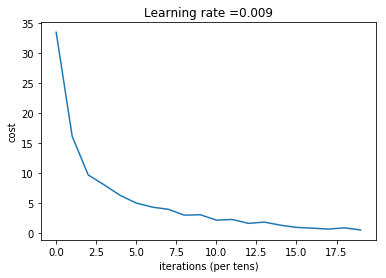

Tensor("Mean_1:0", shape=(), dtype=float32)
Train Accuracy: 0.9537037
Test Accuracy: 0.76666665


In [56]:
_, _, parameters = model(X_train, Y_train, X_test, Y_test)